In [2]:
import keras
import numpy as np
import cv2
import os
import random
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import csv
import zipfile
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import RandomNormal
import keras.backend as k
from sklearn.utils import shuffle
import io
from PIL import Image as pil_image
from keras_retinanet import layers
import keras.backend as k
import keras_retinanet
import random
import pandas
from skimage import measure,color,filters
import matplotlib.pyplot as plt
from scipy.ndimage import binary_opening, binary_dilation
from scipy.ndimage import zoom
import nibabel as nib
from matplotlib import pyplot as plt
import SimpleITK as sitk

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '2,3'
config = tf.compat.v1.ConfigProto(allow_soft_placement = True)
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
# config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [ ]:
Data_path = r'E:\COVID19\dataset\LSCT\2A_images'
train_path = r'E:\\COVID19\\dataset\\LSCT\\train.txt'
train_df = {}
train_df['filename'] =[]
train_df['class'] =[]
val_path = 'E:\\COVID19\\dataset\\LSCT\\val.txt'
val_df = {}
val_df['filename'] =[]
val_df['class'] =[]

test_path = 'E:\\COVID19\\dataset\\LSCT\\test.txt'
test_df = {}
test_df['filename'] =[]
test_df['class'] =[]

with open(train_path, 'r') as f:
        tfnames, tclasses, bboxes = [], [], []
#         count =0
        for line in f.readlines():
            fname, cls, xmin, ymin, xmax, ymax = line.strip('\n').split()
            if int(cls)==0 :
                tfnames.append(os.path.join(Data_path,fname))
#                 tfnames.append(fname)
                tclasses.append('normal')
            if int(cls)==1 :
                tfnames.append(os.path.join(Data_path,fname))
#                 tfnames.append(fname)
                tclasses.append('peno')
            if int(cls)==2 :
                tfnames.append(os.path.join(Data_path,fname))
#                 tfnames.append(fname)
                tclasses.append('covid')
#             count +=1
#             if count ==5:
#                 break
train_df['filename']= tfnames
train_df['class'] =tclasses

with open(val_path, 'r') as f:
        vfnames, vclasses, bboxes = [], [], []
#         count =0
        for line in f.readlines():
            fname, cls, xmin, ymin, xmax, ymax = line.strip('\n').split()
            if int(cls)==0 :
                vfnames.append(os.path.join(Data_path,fname))
#                 vfnames.append(fname)
                vclasses.append('normal')
    
            if int(cls)==1 :
                vfnames.append(os.path.join(Data_path,fname))
#                 vfnames.append(fname)
                vclasses.append('peno')
            if int(cls)==2 :
                vfnames.append(os.path.join(Data_path,fname))
#                 vfnames.append(fname)
                vclasses.append('covid')
#             count +=1
#             if count ==5:
#                 break
val_df['filename']= vfnames
val_df['class'] =vclasses

with open(test_path, 'r') as f:
        tpfnames, tpclasses, bboxes = [], [], []
#         count =0
        for line in f.readlines():
            fname, cls, xmin, ymin, xmax, ymax = line.strip('\n').split()
            if int(cls)==0 :
                tpfnames.append(os.path.join(Data_path,fname))
#                 vfnames.append(fname)
                tpclasses.append('normal')
    
            if int(cls)==1 :
                tpfnames.append(os.path.join(Data_path,fname))
#                 vfnames.append(fname)
                tpclasses.append('peno')
            if int(cls)==2 :
                tpfnames.append(os.path.join(Data_path,fname))
#                 vfnames.append(fname)
                tpclasses.append('covid')
#             count +=1
#             if count ==5:
#                 break
test_df['filename']= tpfnames
test_df['class'] =tpclasses

In [ ]:
training_df = pd.DataFrame(train_df)
t = shuffle(training_df)
validation1_df= pd.DataFrame(validation_df)
v = shuffle(validation1_df)
t.to_csv('E:\\COVID19\\dataset\\LSCT\\CSV\\3_train.csv')
v.to_csv('E:\\COVID19\\dataset\\LSCT\\CSV\\3_val.csv')
testing_df= pd.DataFrame(test_df)
te = shuffle(testing_df)
te.to_csv(r'E:\\COVID19\\dataset\\LSCT\\CSV\\3_test.csv')

# 1. Preprocessing: Get Lung area using Trained Unet

In [ ]:
from models.UNet import *
seg_model = UNet(img_shape = (512,512,1), num_of_class = 1,learning_rate = 2e-4, do_drop = True, drop_rate = 0.5)
model = seg_model.return_model()
model.load_weights('50-0.9898.hdf5')
print('load model successfully')
train_df = pd.read_csv('E:\\COVID19\\dataset\\LSCT\\CSV\\3_train.csv')
validation_df = pd.read_csv('E:\\COVID19\\dataset\\LSCT\\CSV\\3_val.csv')
test_df = pd.read_csv('E:\\COVID19\\dataset\\LSCT\\CSV\\3_test.csv')
train_df[:5]

# 1. Preprocessing: Get lung area using Morphological operation

In [9]:
##  functions for Morphological operation
def bounding_box(array): # 这个函数是得到 图像中有值的区域
    coords = []
    for dim in range(array.ndim):
        axes = list(range(0, array.ndim))
        axes.remove(dim)
#         print('axes is :',axes)
        nonzero = np.any(array, axis = tuple(axes))
#         print(' any ',nonzero.shape)
#         print(np.where(nonzero))
#         print(np.where(nonzero)[0][[0,-1]])
        dim_min, dim_max = np.where(nonzero)[0][[0, -1]]
        coords.append((dim_min, dim_max))
    return coords

def normalize_16bit_dicom_images(cta_image, HU_window=np.array([-1000., 400.]), bound_values=[0, 1]):
    # Outlier
    #mid = (0-HU_window[0])/(HU_window[1] - HU_window[0])
    #cta_image[cta_image == 0] = HU_window[0]

    th_cta_image = (cta_image - HU_window[0])/(HU_window[1] - HU_window[0])
    th_cta_image[th_cta_image < 0] = bound_values[0]
    th_cta_image[th_cta_image >= 1] = bound_values[1]
    th_cta_image_mask = (th_cta_image * 255).astype('uint8')
    return th_cta_image_mask

def zoomed_lung_region(org_img,binary_image):
    ct_imin = np.amin(org_img)
# #     print(ct_imin)
    ct_imax = np.amax(org_img)
#     th_cta_image = (org_img - ct_imin )/(ct_imax - ct_imin)*255 # 归一化到 0-255
    
#     thre =  filters.threshold_otsu(th_cta_image.flatten()) # 基于Otsu的阈值分割方法
# #     print('threshold is : ',thre)
#     binary_image = np.array(th_cta_image <= thre, dtype = np.uint8) # 0 1 二值化  air & lung 为 1

# #     print(binary_image) #1
# #     plt.figure()
# #     plt.subplot(151)
# #     plt.imshow(binary_image)

#     binary_image = binary_dilation(binary_image, iterations = 16)
# #     plt.figure()
# #     plt.subplot(152)
# #     plt.imshow(binary_image)

#     binary_image = np.pad(binary_image, pad_width= 1, mode= 'constant', constant_values = 1)
# #     plt.subplot(153)
# #     plt.imshow(binary_image) # pad image

#     labels_img = measure.label(binary_image)
#     background_label = labels_img[0, 0]
# #     print(background_label)
#     binary_image[labels_img == background_label] = 0
#     # Undo padding
#     binary_image = binary_image[1:-1, 1:-1]
# #     plt.subplot(154)
# #     plt.imshow(binary_image) # lung image
#     binary_image = binary_opening( binary_image, structure = np.ones((3,3), dtype='uint8'), iterations= 8)
#     #     plt.figure()
#     #     plt.imshow(binary_image)
#     labeled = measure.label(binary_image)
#     dst = color.label2rgb(labeled) # 给不同的标签上色
# #     plt.subplot(155)
# #     plt.imshow(dst)

#     labels, counts = np.unique(labeled, return_counts = True) # 去掉重复 并排序输出
# #     print(labels, counts )
#     counts = counts[labels > 0]
#     labels = labels[labels > 0]
#     lab_thres = labels[counts > 14000]
# #     print('thres lab ', lab_thres)
#     org_labeled = labeled.copy()
#     for lab in lab_thres:
# #         print(lab)
#         org_labeled[labeled == lab] = 1 
#     binary_image = np.where(org_labeled == 1,1,0)
#     binary_image = np.uint8(binary_image)
#     plt.figure()
#     plt.imshow(binary_image)
    (y1,y2),(x1,x2) = bounding_box(binary_image)
    
    
    org = (org_img - ct_imin )/(ct_imax - ct_imin)
#     plt.figure()
#     n, bins, patches = plt.hist(x= org.flatten(), bins='auto', color='#0504aa',
#                             alpha=0.7, rwidth=0.85)
#     plt.grid(axis='y', alpha=0.75)
#     plt.xlabel('Value')
#     plt.ylabel('Frequency')
#     plt.title('My Very Own Histogram')
    
    masked_org = binary_image*org
    masked_org  = masked_org[y1:y2, x1:x2]
    zoomed_org = zoom(masked_org, (512/masked_org.shape[0], 512/masked_org.shape[1]))
#     io.imsave('masked_zoomed_lung.jpg',zoomed_org)
    return zoomed_org

In [ ]:
# img_path = '../../CT/External_dataset/Label_segmentation/rp_im/1.nii'
# lesion_mask_path = '../../CT/External_dataset/Label_segmentation/rp_mask/1.nii'
# lung_mask_path = '../../CT/External_dataset/Label_segmentation/rp_lung_msk/1.nii'


# lesion_mask_seq = sitk.ReadImage(lesion_mask_path)
# lesion_mask_seq = sitk.GetArrayFromImage(lesion_mask_seq)

# slices, height, width = lesion_mask_seq.shape
# slice_max = np.max(lesion_mask_seq.reshape((slices, height*width)), axis= 1)
# max_index = np.where(slice_max > 0)



# np.where(np.amax(lesion_mask_seq) == 0,  )

# for i in range(img_seq.shape[0]-10):
#     org_lesion_img  =  lesion_mask_seq[i+10]
#     print(np.amax(org_lesion_img))
#     plt.figure()
#     plt.imshow( org_lesion_img)
    
#     break


In [ ]:
## showing pixel histogram
img_path = '../../CT/External_dataset/Label_segmentation/rp_im/4.nii'
img_seq = sitk.ReadImage(img_path)
img_seq = sitk.GetArrayFromImage(img_seq)

plt.figure()
n, bins, patches = plt.hist(x= img_seq[25].flatten(), bins='auto', color='#0504aa',
                        alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
# plt.savefig('B70s_hist.jpg')
plt.figure()
plt.imshow(img_seq[25])

In [ ]:
img_paths = '../../CT/External_dataset/Label_segmentation/rp_im'
lesion_mask_paths = '../../CT/External_dataset/Label_segmentation/rp_mask'
lung_mask_paths = '../../CT/External_dataset/Label_segmentation/rp_lung_msk'

train_df = {}
train_df['filename'] =[]
train_df['class'] =[]
for index in os.listdir(img_paths):
    print(index)
    filenames = []
    if index.endswith('nii'):
        img_path = os.path.join(img_paths,index)
        lesion_mask_path = os.path.join(lesion_mask_paths,index) 
        lung_mask_path = os.path.join(lung_mask_paths,index) 
        print(lung_mask_path)
        img_seq = sitk.ReadImage(img_path)
        img_seq = sitk.GetArrayFromImage(img_seq)
        lesion_mask_seq = sitk.ReadImage(lesion_mask_path)
        lesion_mask_seq = sitk.GetArrayFromImage(lesion_mask_seq)
        lung_mask_seq = sitk.ReadImage(lung_mask_path)
        lung_mask_seq = sitk.Cast(sitk.RescaleIntensity(lung_mask_seq),sitk.sitkUInt8)
        lung_mask_seq = sitk.GetArrayFromImage(lung_mask_seq)
        
        ################  determine the clip_ratio ############
        lung_mask_seq1 = lung_mask_seq/255
        clip_ratio = 0.08
        slices, height, width = lung_mask_seq1.shape
#         print(slices, height, width)
#         print(np.sum(lung_mask_seq1.reshape((slices, height*width)),axis= -1)/ (height*width))
        #     print('lung_mask shape',slices, height, width) # lung_mask shape 56 512 512
        lung_mask_ratio = np.sum(lung_mask_seq1.reshape((slices, height*width)), axis= 1) / (height*width) # 求z轴上的均值
#         print(lung_mask_ratio)
        left, right = np.min(np.where(lung_mask_ratio > clip_ratio)), \
                       np.max(np.where(lung_mask_ratio > clip_ratio)) # np.where(a > condition) 返回满足 Condition的索引 a[np.where()] 输出值
#         print(left, right)
        ##########################################################
        
        
        ##################  determine the label ##################
        lesion_mask_seq1 = lesion_mask_seq[left:right,...]
        slices1, height1, width1 = lesion_mask_seq1.shape
#         print(slices1, height1, width1)
        slice_max = np.max(lesion_mask_seq1.reshape((slices1, height1*width1)), axis= 1)
#         print(slice_max)
        label_index = np.where(slice_max > 0,'covid','normal') 
#         print(max_index)
        ########################################################## 
        
        save_path = os.path.join('/'.join(img_path.split('/')[:-2]),'Train',index.split('.')[0])
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        save_orgimg_path = os.path.join('/'.join(img_path.split('/')[:-2]),'Train/org_img',index.split('.')[0])
        if not os.path.exists(save_orgimg_path):
            os.makedirs(save_orgimg_path)
        save_orglesion_path = os.path.join('/'.join(img_path.split('/')[:-2]),'Train/lesion_mask',index.split('.')[0])
        if not os.path.exists(save_orglesion_path):
            os.makedirs(save_orglesion_path)
            
        ###################### determin the tarin path ###########
        for i  in range(left,right):
            org_img = img_seq[i,...]
            org_lesion =  lesion_mask_seq[i,...]
            org_lung_mask = lung_mask_seq[i,...]/255
            zoomed_org = zoomed_lung_region(org_img, org_lung_mask)
            
#             plt.figure()
#             plt.imshow(org)
#             plt.figure()
#             plt.imshow(org_lesion)
            save_img_path = save_path + f'/IM000{i}.jpg'
            save_orgimg_path1 = save_orgimg_path + f'/IM000{i}.jpg'
            save_orglesion_path1 = save_orglesion_path + f'/IM000{i}.jpg'
            if not os.path.exists(save_img_path):
                cv2.imwrite(save_img_path,zoomed_org*255)
#             if not os.path.exists(save_orgimg_path1):
            plt.figure()
            fig = plt.gcf()
            fig.set_size_inches(16/3,16/3) #dpi = 300, output = 700*700 pixels
            plt.gca().xaxis.set_major_locator(plt.NullLocator())
            plt.gca().yaxis.set_major_locator(plt.NullLocator())
            plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
            plt.margins(0,0)
            plt.imshow(org_img,cmap = plt.cm.gray)
            plt.savefig(save_orgimg_path1)
            print(save_orgimg_path1)
            
#                 cv2.imwrite(save_orgimg_path1,org_img)
            plt.close()
            if not os.path.exists(save_orglesion_path1):
                cv2.imwrite(save_orglesion_path1,org_lesion)
#             filenames.append(save_img_path)
#             print(save_img_path)
#             plt.figure()
#             plt.imshow(zoomed_org)
#             save_path = 
        
        
#         Updated_lung_mask_seq = lung_mask_seq[left:right,...]
#         print(Updated_lung_mask_seq.shape) 

#         train_df['filename'].extend(filenames)
#         print(len(train_df['filename']))
#         train_df['class'].extend(label_index)
#         print(len(train_df['class']))
#     if not index=='4.nii':
        
# print(train_df)

# 2. Traing branch for diagnosis

In [ ]:
df = pd.DataFrame(train_df)
shuffle(df)
training_df = df[:-96]
validation_df = df[-96:]
training_df.to_csv('CSV/Lesion/lesion_train1.csv')
validation_df.to_csv('CSV/Lesion/lesion_validation1.csv')
print(df[:5])
# print(len(train_df['filename']))
print(len(train_df['class']))

In [2]:
train_df = pd.read_csv('CSV/Lesion/lesion_train1.csv')
validation_df = pd.read_csv('CSV/Lesion/lesion_validation1.csv')

train_datagen = ImageDataGenerator(horizontal_flip = True,vertical_flip=True,zoom_range = 0.05,rotation_range = 360,width_shift_range = 0.05,height_shift_range=0.05,shear_range=0.05)
test_datagen =  ImageDataGenerator()
train_df = shuffle(train_df)
shape=(512,512,1) 
#Create the generators
train_generator = train_datagen.flow_from_dataframe(
      dataframe = train_df,
      directory= None,
      x_col="filename",
      y_col="class",
      target_size=shape[:2],
      batch_size= 10,
      class_mode='categorical',color_mode="grayscale",shuffle=True)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe = validation_df,
        directory = None,
        x_col="filename",
        y_col="class",
        target_size=shape[:2],
        batch_size= 10,
        class_mode='categorical', color_mode="grayscale",shuffle=True)

In [ ]:
def write_lung_lesion(img_path):
    fold_num = img_path.split('/')[-2]
    img_name = img_path.split('/')[-1][:-4]
    slice_num = img_name[5:]
    lung_lesion, zoomed_lung_lesion = get_lung_lesion(img_path)
    
    if not os.path.exists('../../CT/External_dataset/Label_segmentation/Train/Lung_lesion/'+fold_num):
        os.makedirs('../../CT/External_dataset/Label_segmentation/Train/Lung_lesion/'+fold_num)
    if not os.path.exists('../../CT/External_dataset/Label_segmentation/Train/Zoomed_lung_lesion/'+fold_num):
        os.makedirs('../../CT/External_dataset/Label_segmentation/Train/Zoomed_lung_lesion/'+fold_num)
    lung_lesion_path = '../../CT/External_dataset/Label_segmentation/Train/Lung_lesion/'+fold_num+'/'+img_name+'.jpg'
    zoomed_lung_lesion_path = '../../CT/External_dataset/Label_segmentation/Train/Zoomed_lung_lesion/'+fold_num+'/'+img_name+'.jpg'
    if not os.path.exists(lung_lesion_path):
#         print(lung_lesion_path)
        cv2.imwrite(lung_lesion_path, lung_lesion)
        cv2.imwrite(zoomed_lung_lesion_path, zoomed_lung_lesion)
#         print('writing sucess')
    return img_path

In [ ]:
# img_path = train_df['filename'][0]
# print(img_path)
# write_lung_lesion(img_path)
train_df['filename'].map(write_lung_lesion)

In [13]:
fold_num = 1
aph = 2 

In [ ]:
k.clear_session() #Clear keras backend 
# tf.reset_default_graph()
try:
  os.mkdir('models') #create folder for saving the trained networks
except:
  pass
full_name='lesion_ResNet50V2-FPN-fold{}'.format(fold_num)
classes_number = 2 # Number of classes (normal and COVID-19)
input_tensor = Input(shape = shape)
# weight_model = ResNet50V2(weights='imagenet', include_top=False) #Load ResNet50V2 ImageNet pre-trained weights
# weight_model.save_weights('weights.h5') #Save the weights
base_model = ResNet50V2(weights = None, include_top= False, input_tensor = input_tensor) 
# Load the ResNet50V2 model without weights
base_model.load_weights('weights.h5', skip_mismatch=True, by_name = True) #Load the ImageNet weights on the ResNet50V2 model
# #except the first layer(because the first layer has one channel in our case)

#Create Feature Pyramid Network (FPN)
# We used some help for writing the Pyramid from the written code on 
#https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/models/retinanet.py
feature_size = 256 #Set the feature channels of the FPN
layer_names = ["conv4_block1_preact_relu", "conv5_block1_preact_relu", "post_relu"] 
#Layers of ResNet50V2 with different scale features 
layer_outputs = [base_model.get_layer(name).output for name in layer_names]
C3, C4, C5    =  layer_outputs #Features of different scales, extracted from ResNet50V2
P5           = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C5_reduced')(C5)
P5_upsampled = layers.UpsampleLike(name='P5_upsampled')([P5, C4])
P5           = keras.layers.Conv2D(feature_size, kernel_size= 3, strides=1, padding='same', name='P5')(P5)

# Concatenate P5 elementwise to C4
P4           = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C4_reduced')(C4)
P4           = keras.layers.Concatenate(axis=3)([P5_upsampled, P4])
P4_upsampled = layers.UpsampleLike(name='P4_upsampled')([P4, C3])
P4           = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, name='P4')(P4)

# Concatenate P4 elementwise to C3
P3 = keras.layers.Conv2D(feature_size, kernel_size = 1, strides = 1, padding='same', name='C3_reduced')(C3)
P3 = keras.layers.Concatenate(axis=3)([P4_upsampled, P3])
P3 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, name='P3')(P3)

# "P6 is obtained via a 3x3 stride-2 conv on C5"
P6 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P6')(C5)

# "P7 is computed by applying ReLU followed by a 3x3 stride-2 conv on P6"
P7 = keras.layers.Activation('relu', name='C6_relu')(P6)
P7 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P7')(P7)

# Run classification for each of the generated features from the pyramid
feature1 = Flatten()(P3)
dp1 = Dropout(0.5)(feature1)
preds1 = Dense(2, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp1)
#################################################################
feature2 = Flatten()(P4)
dp2 = Dropout(0.5)(feature2)
preds2 = Dense(2, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp2)
#################################################################
feature3 = Flatten()(P5)
dp3= Dropout(0.5)(feature3)
preds3 = Dense(2, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp3)
#################################################################
feature4 = Flatten()(P6)
dp4 = Dropout(0.5)(feature4)
preds4 = Dense(2, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp4)
#################################################################
feature5 = Flatten()(P7)
dp5 = Dropout(0.5)(feature5)
preds5 = Dense(2, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp5)
#################################################################
concat = keras.layers.Concatenate(axis=1)([preds1,preds2,preds3,preds4,preds5]) #Concatenate the predictions(Classification results) of each of the pyramid features 
out = keras.layers.Dense(aph, activation='softmax', kernel_initializer = RandomNormal(mean=0.0, stddev=0.001))(concat) #Final Classification

model = Model(input = base_model.input, output = out) #Create the Training Model
#######################################################
for layer in model.layers:
  layer.trainable = True
model.compile(optimizer= optimizers.nadam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
filepath="models/Lesion/%s-{epoch:02d}-{val_accuracy:.4f}.hdf5" %full_name  # Path to save the trained models
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only = True, mode='max') #creating checkpoint to save the best validation accuracy
callbacks_list = [checkpoint]
 
# model.summary()
hist = model.fit_generator(train_generator, epochs = 20, validation_data = validation_generator, verbose = 1, shuffle=True, callbacks=callbacks_list) #start training

In [ ]:
hist_path = 'History/Epoch_%s_lesion.txt' %len(hist.epoch)
import pickle
with open(hist_path, 'wb') as file_pi:
	pickle.dump(hist.history, file_pi)
file_pi.close()

In [ ]:
print(hist.epoch)
# #  绘制训练 & 验证的准确率值
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(hist.epoch)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(hist.epoch)
plt.show()

# 3. Lesion analysis branch

In [10]:
def grad_cam(model, x, category_index, layer_name):
    """
    Args:
       model: model
       x: image input
       category_index: category index
       layer_name: last convolution layer name
    """
    # get category loss
    class_output = model.output[:, category_index]

    # layer output
    convolution_output = model.get_layer(layer_name).output
    # get gradients
    grads = K.gradients(class_output, convolution_output)[0]
    # get convolution output and gradients for input
    gradient_function = K.function([model.input], [convolution_output, grads])

    output, grads_val = gradient_function([x])
    output, grads_val = output[0], grads_val[0]
#     print('output dtype', weights.dtype)
#     print('output shape', weights.shape)
    # avg
    weights = np.mean(grads_val, axis=(0, 1))
#     print('weight shape', weights.shape)
    
    cam = np.dot(output, weights) # 16×16
#     print('after dot shape', cam.shape)
    ############## for feature detector###########
    piexl_heat_map = np.maximum(cam, 0)
    piexl_heat_map = piexl_heat_map/np.max(piexl_heat_map)
    
    # create heat map
    cam = cv2.resize(cam, (x.shape[1], x.shape[2]), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0) # 逐位比较 去掉非负值
    heatmap = cam / np.max(cam)

    # Return to BGR [0..255] from the preprocessed image
    image_rgb = x[0, :]
    image_rgb -= np.min(image_rgb)
    image_rgb = np.minimum(image_rgb, 255)
#     print('image_rgb shape: ', image_rgb.shape)
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
#     print('before combine : ', cam.shape)
    cam = np.float32(cam) + np.float32(image_rgb) 
#     print('after combine : ', cam.shape)
    cam = 255 * cam / np.max(cam)
# weight shape (2048,)
# dot shape (16, 16)
# image_rgb shape:  (512, 512, 1)
# before combine :  (512, 512, 3)
# after combine :  (512, 512, 3)
    
    return np.uint8(cam), heatmap,piexl_heat_map,output

def lesion_detector(piexl_heat_map,output,feature_path = None,clusterin_map_path = None):
    thre = filters.threshold_otsu(piexl_heat_map.flatten())
    gray_heat = np.where(piexl_heat_map < thre,0,1)
    labeled_img, num = measure.label(gray_heat, connectivity = 2, background = 0, return_num=True)
    properties = measure.regionprops(labeled_img)
    valid_box = []
    indexs = []
    features = []
    for prop in properties:
        valid_box.append(prop.bbox) # min_row, min_col, max_row, max_col
    for i, box in enumerate(valid_box):
        zeros = np.zeros((16,16))
        zeros[box[0]:box[2],box[1]:box[3]] = 1
        mask_heat_map = zeros*piexl_heat_map
        index = np.unravel_index(np.argmax(mask_heat_map), mask_heat_map.shape)
        indexs.append(index) # [(10, 14), (13, 2), (13, 12)]
        feature = output[index[0],index[1],:]
        feature = np.array(feature, dtype = np.float64)
#         print(len(feature))
        if feature_path:
            if not os.path.exists(feature_path):
                os.makedirs(feature_path)
            f_path =  open(os.path.join(feature_path,f'{i}.txt'),'wb')
            np.savetxt(f_path,feature)
            f_path.close()
        features.append(feature)
        label = K_means.predict(np.expand_dims(feature,axis = 0))
        labeled_img[labeled_img == (i+1)] = label+1
#     if label in labels:
#         new_label = labels.index(label) + 1 # 标签是索引 加1，这里索引是从 0开始 labels 是聚类后的标签，索引是连通域的标签
#         labeled_img[labeled_img == (i+1)] = new_label
#     else: labels.append(label)
#     index_labels.append(label[0])
    c = ['b','w','r',"purple",'black','orange']
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(7.0/3,7.0/3) #dpi = 300, output = 700*700 pixels
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.imshow(labeled_img)
    for index in indexs:
        label = labeled_img[index[0],index[1]]
        plt.text(index[1],index[0],label,fontsize= 18, color =c[np.random.randint(0,6)])
#     if clusterin_map_path:
#     plt.title('nihao')
    plt.savefig(clusterin_map_path, dpi=300)
    plt.close()
                                        
    return valid_box,indexs,features 

###### 得到 lung和lesion的背景图像
def get_lung_lesion(img_path):
    lesion_path = '../../CT/External_dataset/Label_segmentation/Train/lesion_mask'
    fold_num = img_path.split('/')[-2]
    img_name = img_path.split('/')[-1][:-4]
    slice_num = img_name[5:]
    
    lesion_img_path = os.path.join(lesion_path,fold_num,img_name+'.jpg')
    lesion_mask_img = cv2.imread(lesion_img_path,cv2.IMREAD_UNCHANGED)+1  # 背景都是 1 lesion 会大于1 
    
    lung_mask_paths = '../../CT/External_dataset/Label_segmentation/rp_lung_msk'
    lung_mask_path = lung_mask_paths+f'/{fold_num}.nii'
    lung_mask_seq = sitk.ReadImage(lung_mask_path)
    lung_mask_seq = sitk.GetArrayFromImage(lung_mask_seq)
    lung_mask_img = lung_mask_seq[int(slice_num),...]

    lung_lesion = lung_mask_img*lesion_mask_img  
    (y1,y2),(x1,x2) = bounding_box(lung_lesion)

    masked_org  = lung_lesion[y1:y2, x1:x2]
    zoomed_lung_lesion = zoom(masked_org, (512/masked_org.shape[0], 512/masked_org.shape[1]))
    return lung_lesion,zoomed_lung_lesion 

In [13]:
############ 加载网络 #####################
netpath = './models/Lesion/lesion_ResNet50V2-FPN-fold1-07-0.9375.hdf5' 
custom_object={'UpsampleLike': keras_retinanet.layers._misc.UpsampleLike}
net = keras.models.load_model(netpath, custom_objects = custom_object)
############ 网络加载成功 #####################

In [ ]:
data_path = '../../CT/External_dataset/Label_segmentation/Train/'
lesion_path = '../../CT/External_dataset/Label_segmentation/Train/lesion_mask'
org_img = '../../CT/External_dataset/Label_segmentation/Train/org_img' 

img_path = validation_generator.filenames[30]

# lesion_path = '../../CT/External_dataset/Label_segmentation/Train/lesion_mask'
# fold_num = img_path.split('/')[-2]
# img_name = img_path.split('/')[-1][:-4]
# slice_num = img_name[5:]

# lesion_img_path = os.path.join(lesion_path,fold_num,img_name+'.jpg')
# lesion_mask_img = cv2.imread(lesion_img_path,cv2.IMREAD_UNCHANGED)+1  # 背景都是 1 lesion 会大于1 

# lung_mask_paths = '../../CT/External_dataset/Label_segmentation/rp_lung_msk'
# lung_mask_path = lung_mask_paths+f'/{fold_num}.nii'
# lung_mask_seq = sitk.ReadImage(lung_mask_path)
# lung_mask_seq = sitk.GetArrayFromImage(lung_mask_seq)
# lung_mask_img = lung_mask_seq[int(slice_num),...]



lung_lesion,zoomed_lung_lesion1 = get_lung_lesion(img_path)
plt.figure()
plt.imshow(zoomed_lung_lesion1)
plt.savefig('pltsave.jpg')
# n, bins, patches = plt.hist(x= lesion_mask_img.flatten(), bins='auto', color='#0504aa',
#                         alpha=0.7, rwidth=0.85)
# plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('My Very Own Histogram')

# plt.figure()
# n, bins, patches = plt.hist(x= lung_mask_img.flatten(), bins='auto', color='#0504aa',
#                         alpha=0.7, rwidth=0.85)
# plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('My Very Own Histogram')

# 4. Model evaluation

In [ ]:
COVID_scores = []
Normal_scores = []
Labels =[]
Pred_label =[]

for num,img_path in enumerate(validation_generator.filenames):
    fold_num = img_path.split('/')[-2]
    img_name = img_path.split('/')[-1][:-4]
    slice_num = img_name[-2:]
#     lung_lesion,zoomed_lung_lesion1 = get_lung_lesion(img_path)
    ##########  验证 ##########
    img_class = validation_generator.classes[num]
    Labels.append(img_class)
    org_img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED) # 获得图像
    img = np.expand_dims(np.expand_dims(org_img, axis = 0),axis=3)
    prit = net.predict(img)[0] #[[9.9945074e-01 5.4921216e-04]]
    COVID_scores.append(prit[0])
    Normal_scores.append(prit[1])
    category_index = np.argmax(prit)
    Pred_label.append(category_index)
    
    
COVID_scores_path = './LUNG_image/Lesion/COVID_scores.txt'
Normal_scores_path = './LUNG_image/Lesion/Normal_scores.txt'
Pred_label_path = './LUNG_image/Lesion/Pred_label.txt'
Labels_path = './LUNG_image/Lesion/Labels.txt'
import pickle
with open(COVID_scores_path, 'wb') as file_pi:
	pickle.dump(COVID_scores, file_pi)
file_pi.close()

with open(Normal_scores_path, 'wb') as file_pi:
	pickle.dump(Normal_scores, file_pi)
file_pi.close()

with open(Pred_label_path, 'wb') as file_pi:
	pickle.dump(Pred_label, file_pi)
file_pi.close()

with open(Labels_path, 'wb') as file_pi:
	pickle.dump(Labels, file_pi)
file_pi.close()

In [ ]:
print(len(COVID_scores))

In [66]:
hit_indexs = []
Lesion_hit = []
num_lesion = []
ratios1 = []

In [64]:
tp = 0
fp =0
tn = 0
fn =0

In [20]:
for num,img_path in enumerate(validation_generator.filenames):
    fold_num = img_path.split('/')[-2]
    img_name = img_path.split('/')[-1][:-4]
    slice_num = img_name[-2:]
    lung_lesion,zoomed_lung = get_lung_lesion(img_path)
    
    
    ##########  验证 ##########
    img_class = validation_generator.classes[num]
    org_img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED) # 获得图像
    img = np.expand_dims(np.expand_dims(org_img, axis = 0),axis=3)
    prit = net.predict(img)[0] #[[9.9945074e-01 5.4921216e-04]]
    category_index = np.argmax(prit)
    print('category_index is %d,img_class is %d'%(category_index,img_class))
    
    if category_index == img_class:
        if category_index == 0:
            tp+=1
            if not os.path.exists(f'./LUNG_image/Lesion/images/PLT_img/{fold_num}'):
                os.makedirs(f'./LUNG_image/Lesion/images/PLT_img/{fold_num}')
                
#             max_val = np.amax(org_img)
#             normalized = (org_img/max_val)*255
#             cv2.imwrite(f'./LUNG_image/Lung/{fold_num}/{num}/{num}_normalized.jpg',normalized)

#             class_output = net.output[:, category_index]
            cam_image, heat_map, piexl_heat_map,output = grad_cam(net,img,category_index,"post_relu")
#             plt.figure()
#             plt.imshow(cam_image)
            heat1_map = cv2.applyColorMap(np.uint8(255 * heat_map), cv2.COLORMAP_JET)
            if not os.path.exists(f'LUNG_image/Lesion/images/{fold_num}/{img_name}_heat.jpg'):
                cv2.imwrite(f'LUNG_image/Lesion/images/{fold_num}/{img_name}_heat.jpg', heat1_map)
            if not os.path.exists(f'LUNG_image/Lesion/images/{fold_num}/{img_name}_cam.jpg'):
                cv2.imwrite(f'LUNG_image/Lesion/images/{fold_num}/{img_name}_cam.jpg', cam_image)
            if not os.path.exists(f'LUNG_image/Lesion/feature/{fold_num}/{img_name}'):
                feature_path = f'LUNG_image/Lesion/feature/{fold_num}/{img_name}'
            else : feature_path = None
                
            clusterin_map_path = f'./LUNG_image/Lesion/images/PLT_img/{fold_num}/{img_name}_new_clustering_map.jpg'
#             if os.path.exists(clusterin_map_path):
#                 clusterin_map_path =None
            valid_box,indexs,features = lesion_detector(piexl_heat_map,output,feature_path,clusterin_map_path) # 根据 16的热力图检测 lesion 特征 并保存
#             labeled_img1, ground_box = ground_lesion_box(zoomed_lung_lesion1) 
#             gray_heat,clustering_base = clustering_distribution(piexl_heat_map) # 16 ×16 的检测图
            
            print(clusterin_map_path)
#             break
            
#             if not ground_box:
#                 continue
#             if not os.path.exists(f'./LUNG_image/Lesion/images/PLT_img/{fold_num}/{img_name}_clustering_base.jpg'):
#                 plt.figure()
#                 fig = plt.gcf()
#                 fig.set_size_inches(7.0/3,7.0/3) #dpi = 300, output = 700*700 pixels
#                 plt.gca().xaxis.set_major_locator(plt.NullLocator())
#                 plt.gca().yaxis.set_major_locator(plt.NullLocator())
#                 plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
#                 plt.margins(0,0)
#                 plt.imshow(clustering_base)
#                 plt.savefig(f'./LUNG_image/Lesion/images/PLT_img/{fold_num}/{img_name}_clustering_base.jpg', dpi=300)
#                 plt.close()
#             if not os.path.exists(f'./LUNG_image/Lesion/images/PLT_img/{fold_num}/{img_name}_Ground_Lesion_distribution.jpg'):
#                 plt.figure()
#                 fig = plt.gcf()
#                 fig.set_size_inches(7.0/3,7.0/3) #dpi = 300, output = 700*700 pixels
#                 plt.gca().xaxis.set_major_locator(plt.NullLocator())
#                 plt.gca().yaxis.set_major_locator(plt.NullLocator())
#                 plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
#                 plt.margins(0,0)
#                 plt.imshow(labeled_img1)
#                 plt.savefig(f'./LUNG_image/Lesion/images/PLT_img/{fold_num}/{img_name}_Ground_Lesion_distribution.jpg', dpi=300)
#                 plt.close()
                
#             cover_rate_map_path = f'./LUNG_image/Lesion/images/PLT_img/{fold_num}/{img_name}_cover_rate_map.jpg'
#             labeled_img2,detected_box,solid_detected_box = detected_lesion_box(piexl_heat_map,heat1_map,cover_rate_map_path) ## 512
#             if not os.path.exists(f'./LUNG_image/Lesion//images/PLT_img/{fold_num}/{img_name}_Detected_Lesion_distribution.jpg'):
#                 plt.figure()
#                 fig = plt.gcf()
#                 fig.set_size_inches(7.0/3,7.0/3) #dpi = 300, output = 700*700 pixels
#                 plt.gca().xaxis.set_major_locator(plt.NullLocator())
#                 plt.gca().yaxis.set_major_locator(plt.NullLocator())
#                 plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
#                 plt.margins(0,0)
#                 plt.imshow(labeled_img2)
#                 plt.savefig(f'./LUNG_image/Lesion/images/PLT_img/{fold_num}/{img_name}_Detected_Lesion_distribution.jpg', dpi=300)
#                 plt.close()
#             if not os.path.exists(f'./LUNG_image/Lesion//images/PLT_img/{fold_num}/{img_name}_solid_Detected_Lesion_distribution.jpg'):
#                 plt.figure()
#                 fig = plt.gcf()
#                 fig.set_size_inches(7.0/3,7.0/3) #dpi = 300, output = 700*700 pixels
#                 plt.gca().xaxis.set_major_locator(plt.NullLocator())
#                 plt.gca().yaxis.set_major_locator(plt.NullLocator())
#                 plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
#                 plt.margins(0,0)
#                 plt.imshow(solid_detected_box)
#                 plt.savefig(f'./LUNG_image/Lesion/images/PLT_img/{fold_num}/{img_name}_solid_Detected_Lesion_distribution.jpg', dpi=300)
#                 plt.close()
#             if not os.path.exists(f'./LUNG_image/Lesion/images/PLT_img/{fold_num}/{img_name}_Lesion_lung.jpg'):
#                 plt.figure()
#                 fig = plt.gcf()
#                 fig.set_size_inches(7.0/3,7.0/3) #dpi = 300, output = 700*700 pixels
#                 plt.gca().xaxis.set_major_locator(plt.NullLocator())
#                 plt.gca().yaxis.set_major_locator(plt.NullLocator())
#                 plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
#                 plt.margins(0,0)
#                 plt.imshow(zoomed_lung )
#                 plt.savefig(f'./LUNG_image/Lesion//images/PLT_img/{fold_num}/{img_name}_Lesion_lung.jpg', dpi=300)
#                 plt.close()
#             if not os.path.exists(f'./LUNG_image/Lesion/images/PLT_img/{fold_num}/{img_name}_Org_img.jpg'):
#                 plt.figure()
#                 fig = plt.gcf()
#                 fig.set_size_inches(7.0/3,7.0/3) #dpi = 300, output = 700*700 pixels
#                 plt.gca().xaxis.set_major_locator(plt.NullLocator())
#                 plt.gca().yaxis.set_major_locator(plt.NullLocator())
#                 plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
#                 plt.margins(0,0)
#                 plt.imshow(org_img)
#                 plt.savefig(f'./LUNG_image/Lesion/images/PLT_img/{fold_num}/{img_name}_Org_img.jpg', dpi=300)
#                 plt.close()
#             if not os.path.exists(f'./LUNG_image/Lesion/images/PLT_img/{fold_num}/{img_name}_Lesion_cam.jpg'):
#                 plt.figure()
#                 fig = plt.gcf()
#                 fig.set_size_inches(7.0/3,7.0/3) #dpi = 300, output = 700*700 pixels
#                 plt.gca().xaxis.set_major_locator(plt.NullLocator())
#                 plt.gca().yaxis.set_major_locator(plt.NullLocator())
#                 plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
#                 plt.margins(0,0)
#                 plt.imshow(cam_image)
#                 plt.savefig(f'./LUNG_image/Lesion/images/PLT_img/{fold_num}/{img_name}_Lesion_cam.jpg', dpi=300)
#                 plt.close()
            
#             ratios = hit_rate(detected_box,ground_box)
#             print(ratios)
# #             print("num_lesion :",len(ground_box))
#             num_lesion.append(len(ground_box))
#             ratios1.append(ratios) #####  每一张 每一个 leison的命中率
# #             print(ratios1)
#             hit_index = np.max(ratios,axis=1)
#             hit_indexs.append(hit_index)
#             new_index = np.where(hit_index> 0.1,1,0)
# #             print("detect_num_lesion: ",sum(new_index))
#             Lesion_hit.append(new_index)
#         else : tn +=1
# #             gray_heatmap = cv2.cvtColor(heat_map,cv2.COLOR_BGR2GRAY)
# #             cv2.imwrite(f'./LUNG_image/Lung/{fold_num}/{num}/{num}_gray_heatmap.jpg', gray_heatmap)
# # #             boxed_image, boxed_cam = draw_box(org_img,cam_image,heat_map)
# # #             max_val = np.amax(org_img)
# # #             normalized = (org_img/max_val)
# # #             cv2.imwrite(f'./result_img/lung_region_train/{num}/{num}_normalized_org_img.jpg', normalized*255)
# # #             cv2.imwrite(f'./result_img/lung_region_train/{num}/{num}_boxed_img.jpg', boxed_image)
# # #             cv2.imwrite(f'./result_img/lung_region_train/{num}/{num}_boxed_cam_img.jpg', boxed_cam)
#     else:
#         if img_class == 1: 
#             fp +=1
#         else: fn +=1
# #     if num == 3 :
#         break
# validation_file.close()


category_index is 1,img_class is 1
category_index is 0,img_class is 1
category_index is 1,img_class is 1
category_index is 0,img_class is 0
./LUNG_image/Lesion/images/PLT_img/3/IM000150_new_clustering_map.jpg
category_index is 1,img_class is 1
category_index is 1,img_class is 0
category_index is 0,img_class is 0
./LUNG_image/Lesion/images/PLT_img/3/IM000136_new_clustering_map.jpg
category_index is 0,img_class is 0
./LUNG_image/Lesion/images/PLT_img/8/IM0006_new_clustering_map.jpg
category_index is 0,img_class is 0
./LUNG_image/Lesion/images/PLT_img/5/IM00027_new_clustering_map.jpg
category_index is 0,img_class is 0
./LUNG_image/Lesion/images/PLT_img/9/IM00030_new_clustering_map.jpg
category_index is 0,img_class is 0
./LUNG_image/Lesion/images/PLT_img/6/IM00021_new_clustering_map.jpg
category_index is 0,img_class is 0
./LUNG_image/Lesion/images/PLT_img/3/IM00097_new_clustering_map.jpg
category_index is 1,img_class is 1
category_index is 0,img_class is 0
./LUNG_image/Lesion/images/PLT_im

In [ ]:
print(tp,tn,fp,fn)
# plt.figure()
# fig = plt.gcf()
# fig.set_size_inches(7.0/3,7.0/3) #dpi = 300, output = 700*700 pixels
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
# plt.margins(0,0)
# plt.imshow(zoomed_lung_lesion1)
# # plt.savefig(f'./LUNG_image/Lesion//images/PLT_img/{fold_num}/{img_name}_Lesion_lung.jpg', dpi=300)

In [ ]:
print(len(Lesion_hit))
print(len(num_lesion))
print(ratios1 )

In [ ]:
sum(num_lesion)

In [ ]:
hit = np.array(Lesion_hit)
count =0
for i in hit:
#     print(i,sum(i))
    count += sum(i)
#     print(count)
    
print(count)
print(sum(num_lesion))
print(len(num_lesion))
print(len(Lesion_hit))
print(71/112)

In [ ]:
def thre(Problist,thres):
    number = len(Problist)
    Problist2 = Problist.copy()
    tp =  len(np.where(Problist2 > thres)[0])
    fp =  number-tp
#     print(number,tp,fp)
    tpr = tp/number
    fps = fp/totalNumberOfImages
    return tp,fp

In [ ]:
Lesion_hit

In [ ]:
from sklearn import metrics 
totalNumberOfImages = len(Lesion_hit)

GTlist = []
Problist = []
numberOfDetectedLesions = 0
for i in  range(totalNumberOfImages):
    numberOfDetectedLesions += sum(Lesion_hit[i])
#     print(numberOfDetectedLesions)
    GTlist.extend(Lesion_hit[i])
    Problist.extend(Lesion_hit_rate[i])
print(numberOfDetectedLesions)
print(len(GTlist))
# GTlist = np.array(GTlist)
# Problist = np.array(Problist)
# number = len(Problist)
# # #     print(tpr,fps)
# for i in np.arange(0,1,0.1):
#     print(i)
# #     Problist1 = Problist
#     tp,fp = thre(Problist,i) # 0.5918367346938775 1.0256410256410255
#     pericsion = tp/number
#     fps = fp/totalNumberOfImages
#     print(tp,fp,tpr,fps)

# numberOfDetectedLesions = sum(GTlist)
# totalNumberOfCandidates = len(Problist)
# fpr, tpr, thresholds = metrics.roc_curve(GTlist, Problist, pos_label = 1)
# print(fpr, tpr)
# # FROC
# fps = fpr * (totalNumberOfCandidates - numberOfDetectedLesions) / totalNumberOfImages
# sens = tpr
 
 
# fps_itp = np.linspace(0.125, 8, num=10001)
# sens_itp = np.interp(fps_itp, fps, sens)
# frvvlu = 0
# nxth = 0.125
# for fp, ss in zip(fps_itp, sens_itp):
#     if abs(fp - nxth) < 3e-4:
#         print(ss)
#         frvvlu += ss
#         nxth *= 2
#     if abs(nxth - 16) < 1e-5: break
# print(frvvlu / 7, nxth)
 
# #画图
# plt.plot(fps, sens, color='b', lw=2)
# plt.legend(loc='lower right')
# # plt.plot([0, 1], [0, 1], 'r--')
# plt.xlim([0.125, 1])
# plt.ylim([0, 1.1])
# plt.xlabel('Average number of false positives per scan') #横坐标是fpr
# plt.ylabel('True Positive Rate')  #纵坐标是tpr
# plt.title('FROC performence')


In [ ]:
print(np.array(Lesion_hit))

In [ ]:
import pickle
path = 'lesion_predicition.txt'
with open(path, 'wb') as f1:
    pickle.dump(prediction, f1)
f1.close()

In [1]:
COVID_scores_path = './LUNG_image/Lesion/COVID_scores.txt'
Normal_scores_path = './LUNG_image/Lesion/Normal_scores.txt'
Pred_label_path = './LUNG_image/Lesion/Pred_label.txt'
Labels_path = './LUNG_image/Lesion/Labels.txt'
import pickle

with open(COVID_scores_path , 'rb') as f1:
       COVID_scores = pickle.load(f1)
f1.close()

with open(Normal_scores_path, 'rb') as f1:
       Normal_scores = pickle.load(f1)
f1.close()

with open(Pred_label_path, 'rb') as f1:
       Pred_label = pickle.load(f1)
f1.close()

with open(Labels_path, 'rb') as f1:
       Labels = pickle.load(f1)
f1.close()

In [ ]:
print(Labels)

In [ ]:
import pickle
path = 'lesion_predicition.txt'
with open(path, 'rb') as f1:
       Pred_label = pickle.load(f1)
f1.close()

In [3]:
# Labels
# COVID_scores
# Pred_label

验证准确率 

Average precision-recall score: 0.87
[0.0347012  0.03553674 0.04734358 0.05069415 0.067835   0.1273199
 0.1282142  0.31893474 0.38957763 0.5556125  0.6144552  0.8351753
 0.8480713  0.8673163  0.9137759  0.92478806 0.92777914 0.93583095
 0.94409865 0.95133775 0.95379597 0.95664316 0.96789336 0.9731502
 0.9751751  0.98506457 0.9877659  0.99022466 0.9921063  0.99458945
 0.99543285 0.996402   0.9967411  0.9979195  0.9980167  0.99852943
 0.99856025 0.9987301  0.9993487  0.99940264 0.9995646  0.99957615
 0.99976176 0.9997819  0.9997937  0.9998454  0.999858   0.99985933
 0.99988663 0.9998932  0.99994755 0.999951   0.99995303 0.99996734
 0.9999714  0.9999716  0.99998    0.99998975 0.9999918  0.99999714
 0.9999981  0.99999917 0.9999993  0.99999964 0.9999999  1.        ] [0.76388889 0.76056338 0.75714286 0.76811594 0.77941176 0.79104478
 0.8030303  0.81538462 0.8125     0.82539683 0.82258065 0.83606557
 0.83333333 0.83050847 0.82758621 0.8245614  0.83928571 0.83636364
 0.83333333 0.83018868 0.82

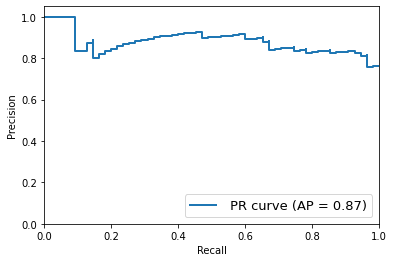

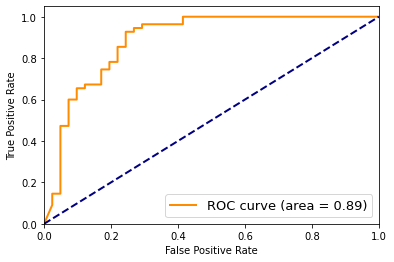

[0.         0.02439024 0.02439024 0.02439024 0.04878049 0.04878049
 0.07317073 0.07317073 0.09756098 0.09756098 0.12195122 0.12195122
 0.17073171 0.17073171 0.19512195 0.19512195 0.2195122  0.2195122
 0.24390244 0.24390244 0.26829268 0.26829268 0.29268293 0.29268293
 0.41463415 0.41463415 1.        ] [0.         0.09090909 0.12727273 0.14545455 0.14545455 0.47272727
 0.47272727 0.6        0.6        0.65454545 0.65454545 0.67272727
 0.67272727 0.74545455 0.74545455 0.78181818 0.78181818 0.85454545
 0.85454545 0.92727273 0.92727273 0.94545455 0.94545455 0.96363636
 0.96363636 1.         1.        ] [1.         0.97560976 0.97560976 0.97560976 0.95121951 0.95121951
 0.92682927 0.92682927 0.90243902 0.90243902 0.87804878 0.87804878
 0.82926829 0.82926829 0.80487805 0.80487805 0.7804878  0.7804878
 0.75609756 0.75609756 0.73170732 0.73170732 0.70731707 0.70731707
 0.58536585 0.58536585 0.        ]


In [6]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

for i in range(1):
    lw = 2
    label = Labels
    COVID_score = COVID_scores
    pred_label  = Pred_label
    
    average_precision = average_precision_score(label, COVID_score,pos_label= 0)

    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))

    precision, recall, _ = precision_recall_curve(label, COVID_score, pos_label= 0)
    print(_,precision,recall)
    plt.figure()
    plt.step(recall, precision,where="pre",lw=lw, label=' PR curve (AP = %0.2f)' % average_precision)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
#     plt.title(
#         'COVID Positive-Precision and Recall curve on SSCT'
#         )
    plt.legend(loc="lower right", prop = {'size':13})
#     Average_precision[f'{i+1}] = average_precision
#     Precision[f'{i+1}'] = precision
#     Recall[f'{i+1}'] = recall
    plt.savefig('LUNG_image/Lesion/lesion_PR.jpg',bbox_inches='tight', dpi=300)
    plt.show()
    
    ###################### Confusion  #######################
#     cm = confusion_matrix(label, pred_label)
#     tn, fp, fn, tp = cm.ravel()
# #     print(tn, fp, fn, tp)
#     plt.figure()
    
#     labels_name =['0','1']
#     plt.figure()
#     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
#     plt.imshow(cm, interpolation='nearest')    # 在特定的窗口上显示图像
#     plt.title("COVID-19 Confusion Matrix")    # 图像标题
#     plt.colorbar()
#     num_local = np.array(range(len(labels_name)))    
#     plt.xticks(num_local, labels_name)    # 将标签印在x轴坐标上
#     plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
#     plt.ylabel('True label')    
#     plt.xlabel('Predicted label')
    
#     cm_display = ConfusionMatrixDisplay(cm).plot()
#     plt.title('COVID-19 Confusion matrix of SSCT')
#     fig = plt.gcf()
#     fig.set_size_inches(16/3,16/3) #dpi = 300, output = 700*700 pixels
# #     plt.gca().xaxis.set_major_locator(plt.NullLocator())
# #     plt.gca().yaxis.set_major_locator(plt.NullLocator())
# #     plt.subplots_adjust(top = 1, bottom = 0, right = 2, left = 1, hspace = 0, wspace = 0)
#     plt.margins(0,0)
#     Confusion_matrix[f'{i+1}'] =[tn, fp, fn, tp] 
#     plt.savefig('LUNG_image/Lesion/lesion_CM.jpg', dpi=300)
    
    
    ###################### ROC & auc  #######################
    fpr, tpr, _ = roc_curve(label, COVID_score, pos_label= 0 )
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
#     plt.title('COVID-19 Receiver operating characteristic on SSCT ')
    plt.legend(loc = "lower right",prop = {'size':13})
    
    plt.savefig('LUNG_image/Lesion/lesion_ROC.jpg',bbox_inches='tight', dpi=300)
    plt.show()
#     Roc_curve[f'{i+1}'] = {}
#     Roc_curve[f'{i+1}']['fpr'] = fpr
#     Roc_curve[f'{i+1}']['tpr'] = tpr
#     Roc_auc[f'{i+1}'] = roc_auc
    print(fpr, tpr,1-fpr)

In [57]:
###### 根据 16×16 热力图来计算 标注lesion的框 ######
def clustering_distribution(pixel_heat_map):
#     plt.figure()
#     plt.imshow(pixel_heat_map)
#     pixel_heat_map = piexl_heat_map
    thre = filters.threshold_otsu(pixel_heat_map.flatten())
#     print(thre)
    gray_heat = np.where(pixel_heat_map < thre,0,1)

#     plt.figure()
#     plt.imshow(gray_heat)
#     plt.show()
#     print(gray_heat)
    labeled_img, num = measure.label(gray_heat, connectivity = 2, background = 0, return_num=True)
#     plt.figure()
#     plt.imshow(labeled_img)
#     plt.show()
#     print(num)
#     print(labeled_img)
    return gray_heat,labeled_img

###### 根据热GT  512×512 来计算 标注lesion的框 ######
def ground_lesion_box(lesion_img2):

    lesion_img2[np.where(lesion_img2==1)] =0  ## 将 lung区域 也变为背景 

#     plt.figure()
#     plt.imshow(lesion_img2)

    lesion_img3 = np.where(lesion_img2 == 0,0,1) # 将lesion 变为 1
#     plt.figure()
#     plt.imshow(lesion_img3)
    
    labeled_img3, num = measure.label(lesion_img3*255, connectivity = 1, background = 0, return_num=True)
#     plt.figure()
#     plt.imshow(labeled_img3)
    
#     plt.savefig('./LUNG_image/Lesion/Ground_Lesion_distribution.jpg', dpi=300)
#     print(num)
    properties3 = measure.regionprops(labeled_img3)
    ground_valid_box = []
    for prop in properties3:
         if prop.area > 360:
            ground_valid_box.append(prop.bbox)
    return labeled_img3, ground_valid_box

####### 根据热力图  512×512 来计算 lesion的框 ######
def detected_lesion_box(pixel_heat_map,heat1_map,cover_rate_map_path = None):
    thre = filters.threshold_otsu(pixel_heat_map.flatten())
    gray_heatmap = cv2.cvtColor(heat1_map,cv2.COLOR_BGR2GRAY)
    box_region = np.where(gray_heatmap > thre*255, 255, 0)

    # print(thre1)
#     plt.figure()
#     plt.imshow(heat1_map)
#     plt.figure()
#     plt.imshow(box_region)
#     # cv2.imwrite('img_gray.jpg',img_gray)
    
    labeled_img, num = measure.label(box_region,connectivity = 2, background = 0, return_num=True)
    properties = measure.regionprops(labeled_img)
    valid_box = []
    for prop in properties:
        if prop.area > 32 :
            valid_box.append(prop.bbox)
    
    heat_zeros = np.zeros((512,512))
    
    cover_rates = []
    for i, box in enumerate(valid_box):  #展示每个box
        heat_zeros[box[0]:box[2],box[1]:box[3]] = i+1
        y1,x1,y2,x2 = box
        temp_rates = []
        for j in ground_box:
            y_1,x_1,y_2,x_2 = j 
            temp_rates.append(DecideOberlap(x1,y1,x2,y2,x_1,y_1,x_2,y_2))
        cover_rates.append(np.max(temp_rates))
   

    c = ['b','w','r',"purple",'black','orange']
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(7.0/3,7.0/3) #dpi = 300, output = 700*700 pixels
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.imshow(heat_zeros)
    for i, box in enumerate(valid_box):
        y1,x1,y2,x2 = box
        plt.text((x1+x2)/2-20,(y1+y2)/2,cover_rates[i],fontsize= 14, color =c[np.random.randint(0,6)])
    if cover_rate_map_path:
        plt.savefig(cover_rate_map_path,dpi = 300)
    plt.close()
    return labeled_img,valid_box,heat_zeros

############### 计算两个框的重叠率 ####################     
def DecideOberlap(BBox_x1, BBox_y1, BBox_x2, BBox_y2, BBox_gt_x1, BBox_gt_y1, BBox_gt_x2, BBox_gt_y2):
    x1 = BBox_x1;
    y1 = BBox_y1;
    width1  = BBox_x2 - BBox_x1;
    height1 = BBox_y2 - BBox_y1;

    x2 = BBox_gt_x1;
    y2 = BBox_gt_y1;
    width2  = BBox_gt_x2 - BBox_gt_x1;
    height2 = BBox_gt_y2 - BBox_gt_y1;

    endx     = np.max([x1+width1, x2+width2]);
    startx    = np.min([x1, x2]);
    width     = width1 + width2 - (endx - startx);

    endy = np.max([y1 + height1, y2 + height2]);
    starty = np.min([y1, y2]);
    height = height1 + height2 - (endy - starty);

    if width<=0 or height<=0: 
         ratio = 0
    else:
         Area = width*height;
         Area1 = width1*height1
         Area2 = width2*height2
         ratio = Area/Area2;
    return ratio 

##########  计算每个到 lesion 与金标的 重叠率 ############
def hit_rate(detected_box1,ground_box2):
    ratios = []
#     len1 =len(valid_box1)
#     len2 =len(valid_box2)
    for box1 in detected_box1:
        ratio = []
        for box2 in ground_box2:
            y1,x1,y2,x2 = box1
            y_1,x_1,y_2,x_2 = box2 
            ratio.append(DecideOberlap(x1,y1,x2,y2,x_1,y_1,x_2,y_2))
        ratios.append(ratio)
    return ratios    

# 5. Showing detected lesion

../../CT/External_dataset/Label_segmentation/Train/3/IM000150.jpg
0 0
[(413, 81, 503, 212)]
1
[[1.0], [0]]
1
[1. 0.]
[1 0]


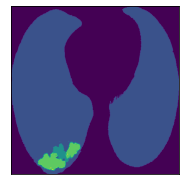

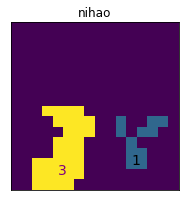

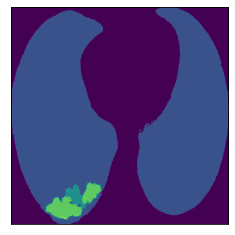

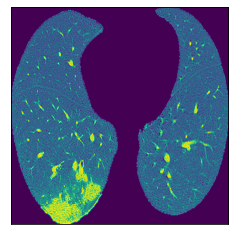

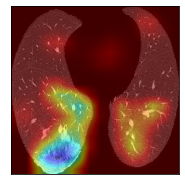

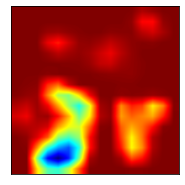

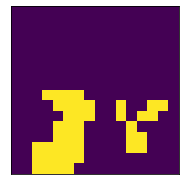

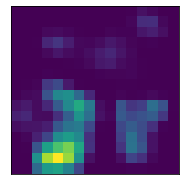

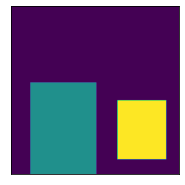

In [79]:
img_path = validation_generator.filenames[3]
img_class = validation_generator.classes[3]
print(img_path)
fold_num = img_path.split('/')[-2]
img_name = img_path.split('/')[-1][:-4]
slice_num = img_name[-2:]
lung_lesion,zoomed_lung_lesion1 = get_lung_lesion(img_path)
plt.figure()
fig = plt.gcf()
fig.set_size_inches(7.0/3,7.0/3) #dpi = 300, output = 700*700 pixels
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.imshow(zoomed_lung_lesion1)


org_img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED) # 获得图像
img = np.expand_dims(np.expand_dims(org_img, axis = 0),axis=3)
prit = net.predict(img)[0] #[[9.9945074e-01 5.4921216e-04]]

category_index = np.argmax(prit)
print(category_index,img_class)


if category_index == img_class:
    if category_index == 0:
        if not os.path.exists(f'./LUNG_image/Lesion/images/{fold_num}'):
                os.makedirs(f'./LUNG_image/Lesion/images/{fold_num}')
            
                #             max_val = np.amax(org_img)
                #             normalized = (org_img/max_val)*255
                #             cv2.imwrite(f'./LUNG_image/Lung/{fold_num}/{num}/{num}_normalized.jpg',normalized)

                #             class_output = net.output[:, category_index]
        cam_image, heat_map, pixel_heat_map, output = grad_cam(net,img,category_index,"post_relu")
        #             plt.figure()
        #             plt.imshow(cam_image)
        heat1_map = cv2.applyColorMap(np.uint8(255 * heat_map), cv2.COLORMAP_JET)
#                 cv2.imwrite(f'LUNG_image/Lesion/images/{fold_num}/{img_name}_heat.jpg', heat1_map)
#                 cv2.imwrite(f'LUNG_image/Lesion/images/{fold_num}/{img_name}_cam.jpg', cam_image)

        feature_path = None
        clusterin_map_path = f'./LUNG_image/Lesion/images/PLT_img/{fold_num}/{img_name}_clustering_map.jpg'
        valid_box,indexs,features = lesion_detector(pixel_heat_map,output,feature_path,clusterin_map_path) # 提取lesion特征 
        plt.figure()
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.imshow(zoomed_lung_lesion1)
#         plt.savefig('./LUNG_image/Lesion/Lesion_lung.jpg', dpi=300)
        plt.figure()
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.imshow(org_img)
#         plt.savefig('./LUNG_image/Lesion/Org_img.jpg', dpi=300)
        plt.figure()
        fig = plt.gcf()
        fig.set_size_inches(7.0/3,7.0/3) #dpi = 300, output = 700*700 pixels
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.imshow(cam_image)
#         plt.savefig('./LUNG_image/Lesion/Lesion_cam.jpg', dpi=300)
        
        plt.figure()
        fig = plt.gcf()
        fig.set_size_inches(7.0/3,7.0/3) #dpi = 300, output = 700*700 pixels
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.imshow(heat1_map)
        
        
        gray_heat,clustering_base = clustering_distribution(pixel_heat_map)
        
        plt.figure()
        fig = plt.gcf()
        fig.set_size_inches(7.0/3,7.0/3) #dpi = 300, output = 700*700 pixels
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.imshow(gray_heat)
        
        
        plt.figure()
        fig = plt.gcf()
        fig.set_size_inches(7.0/3,7.0/3) #dpi = 300, output = 700*700 pixels
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.imshow(pixel_heat_map)
        
        label_img, ground_box = ground_lesion_box(zoomed_lung_lesion1)
        print(ground_box)
        print(len(ground_box))
        if not ground_box:
            print('lieb kong l')
        label_img2, detected_box, solid_detected_box = detected_lesion_box(pixel_heat_map,heat1_map)
        
        plt.figure()
        fig = plt.gcf()
        fig.set_size_inches(7.0/3,7.0/3) # dpi = 300, output = 700*700 pixels
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.imshow(solid_detected_box)
        
        ratios = hit_rate(detected_box,ground_box)
        print(ratios)
        num_resion = len(ratios[0])
        print(num_resion)
        index = np.max(ratios,axis=1)
        print(index)
        new_index = np.where(index> 0.1,1,0)
        print(new_index)
#         index.append(new_index) 

# ../../CT/External_dataset/Label_segmentation/Train/5/IM00027.jpg
# 0 0
# 0.27539062
# [(192, 52, 229, 86), (248, 414, 298, 500), (323, 156, 377, 209), (328, 357, 479, 460), (419, 86, 479, 123)]
# 5
# [[0.5961844197138315, 0, 0, 0, 0], [0, 0, 0, 1.0, 0], [0, 0, 0.20964360587002095, 0, 0], [0, 0, 0, 0, 0.595945945945946]]
# 5
# [0.59618442 1.         0.20964361 0.59594595]
# [1 1 1 1]

In [20]:
# cover_rate_map_path = f'./LUNG_image/Lesion/images/PLT_img/{fold_num}/{img_name}_cover_rate_map.jpg'
cover_rate_map_path = None
detected_lesion_box(pixel_heat_map,heat1_map,cover_rate_map_path) 

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 [(233, 59, 512, 260), (287, 324, 467, 473)],
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

0.23632812


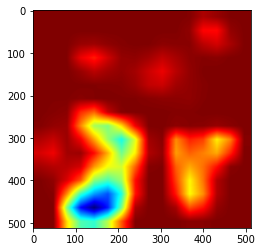

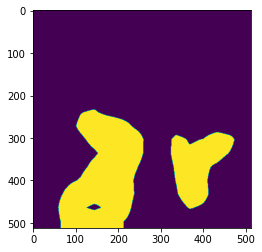

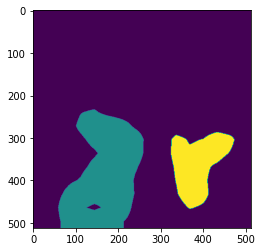

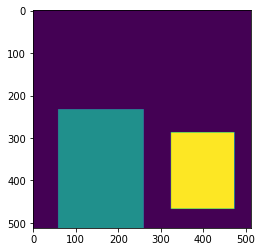

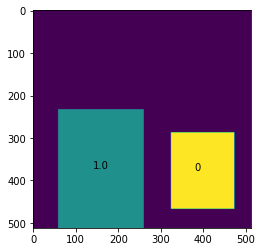

In [21]:
thre = filters.threshold_otsu(pixel_heat_map.flatten())
gray_heatmap = cv2.cvtColor(heat1_map,cv2.COLOR_BGR2GRAY)
box_region = np.where(gray_heatmap > thre*255, 255, 0)

print(thre)
plt.figure()
plt.imshow(heat1_map)
plt.figure()
plt.imshow(box_region)
#     # cv2.imwrite('img_gray.jpg',img_gray)

labeled_img, num = measure.label(box_region,connectivity = 2, background = 0, return_num=True)
properties = measure.regionprops(labeled_img)

    
valid_box = []
for prop in properties:
    if prop.area > 64:
        valid_box.append(prop.bbox)
heat_zeros = np.zeros((512,512))
cover_rates = []
for i, box in enumerate(valid_box):  #展示每个box
    heat_zeros[box[0]:box[2],box[1]:box[3]] = i+1
    y1,x1,y2,x2 = box
    temp_rates = []
    for j in ground_box:
        y_1,x_1,y_2,x_2 = j 
        temp_rates.append(DecideOberlap(x1,y1,x2,y2,x_1,y_1,x_2,y_2))
    cover_rates.append(np.max(temp_rates))
   
plt.figure()
plt.imshow(labeled_img)

plt.figure()
plt.imshow(heat_zeros)

plt.figure()
plt.imshow(heat_zeros)
for i, box in enumerate(valid_box):
    y1,x1,y2,x2 = box
    plt.text((x1+x2)/2-20,(y1+y2)/2,cover_rates[i])
plt.show()


# 6. Capture the detected lesion feature 

(16, 16, 2048)
0.23632812
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0]
 [0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 0]
 [0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0]
 [0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0]
 [0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]]


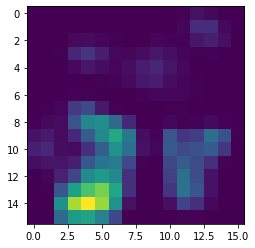

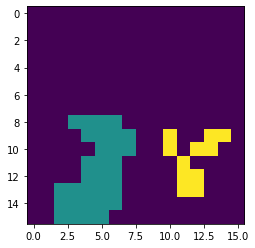

2
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 0 0 2 0 0 2 2 0]
 [0 0 0 0 0 1 1 1 0 0 2 0 2 2 0 0]
 [0 0 0 0 1 1 1 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 1 1 1 0 0 0 0 2 2 0 0 0]
 [0 0 1 1 1 1 1 0 0 0 0 2 2 0 0 0]
 [0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]]
(14, 4)
2048
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 0 0 2 0 0 2 2 0]
 [0 0 0 0 0 1 1 1 0 0 2 0 2 2 0 0]
 [0 0 0 0 1 1 1 0 0 0 0 2 0 0 0 0]
 [0 

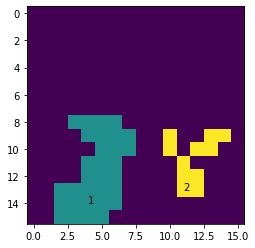

In [24]:
# feature_path =f'LUNG_image/Lesion/feature/{fold_num}/{img_name}'
# def lesion_detector(piexl_heat_map,output,feature_path):
#     if not os.path.exists(feature_path):
#         os.makedirs(feature_path)
    
#     thre = filters.threshold_otsu(pixel_heat_map.flatten())
#     gray_heat = np.where(pixel_heat_map < thre,0,1)
#     labeled_img, num = measure.label(gray_heat, connectivity = 2, background = 0, return_num=True)
#     properties = measure.regionprops(labeled_img)
#     valid_box = []
#     indexs = []
#     features = []
#     for prop in properties:
#         valid_box.append(prop.bbox) # min_row, min_col, max_row, max_col
#     for i, box in enumerate(valid_box):
#         zeros = np.zeros((16,16))
#         zeros[box[0]:box[2],box[1]:box[3]] = 1
#         mask_heat_map = zeros*pixel_heat_map
#         index = np.unravel_index(np.argmax(mask_heat_map), mask_heat_map.shape)
#         indexs.append(index) # [(10, 14), (13, 2), (13, 12)]
#         feature = output[index[0],index[1],:]
#         feature = np.array(feature, dtype = np.float64)
#         print(len(feature))
#         f_path =  open(os.path.join(feature_path,f'{i}.txt'),'wb')
#         np.savetxt(f_path,feature)
#         features.append(feature)
#         f_path.close()
#     return indexs,features 
# indexs,features = lesion_detector(piexl_heat_map,output,feature_path) 
        
print(output.shape)

plt.figure()
plt.imshow(pixel_heat_map)
# pixel_heat_map = piexl_heat_map
thre = filters.threshold_otsu(pixel_heat_map.flatten())
print(thre)
gray_heat = np.where(pixel_heat_map < thre,0,1)

# plt.figure()
# plt.imshow(gray_heat)
# plt.show()
print(gray_heat)
labeled_img, num = measure.label(gray_heat, connectivity = 2, background = 0, return_num=True)
plt.figure()
plt.imshow(labeled_img)
plt.show()
print(num)
print(labeled_img)

properties = measure.regionprops(labeled_img)
valid_box = []
indexs = []    # 每个lesion 极值点坐标
features = []
for prop in properties:
        valid_box.append(prop.bbox) # min_row, min_col, max_row, max_col
labels = []   
for i, box in enumerate(valid_box):
#     print(box)
#     [(9, 13, 11, 16), (12, 1, 16, 5), (12, 10, 16, 15)]
    zeros = np.zeros((16,16))
    zeros[box[0]:box[2],box[1]:box[3]] = 1 #测试 box的大小 
# #     np.agrmax(cam[box[0]:box[2],box[1]:box[3]])
    mask_heat_map = zeros*pixel_heat_map
    index = np.unravel_index(np.argmax(mask_heat_map), mask_heat_map.shape)
    indexs.append(index) # [(10, 14), (13, 2), (13, 12)]
    print(index)
    feature = output[index[0],index[1],:]
#     print(feature.dtype)
    feature =np.array(feature, dtype = np.float64)
    print(len(feature))
    if not os.path.exists(f'LUNG_image/Lesion/feature/{fold_num}/{img_name}'):
        os.makedirs(f'LUNG_image/Lesion/feature/{fold_num}/{img_name}')
#     f_path =  open(f'LUNG_image/Lesion/feature/{fold_num}/{img_name}/{i}.txt','a+')
#     np.savetxt(f_path,feature)
#     f_path.close()
    
    label = K_means.predict(np.expand_dims(feature,axis = 0))
    labeled_img[labeled_img == (i+1)] = label+1
#     if label in labels:
#         new_label = labels.index(label) + 1 # 标签是索引 加1，这里索引是从 0开始 labels 是聚类后的标签，索引是连通域的标签
#         labeled_img[labeled_img == (i+1)] = new_label
#     else: labels.append(label)
#     index_labels.append(label[0])
    print(labeled_img)

plt.figure()
plt.imshow(labeled_img)
for index in indexs:
    label = labeled_img[index[0],index[1]]
    plt.text(index[1],index[0],label)
plt.show()

In [ ]:
print(indexs)

# 7. Clustering the lesion

In [3]:
import os
import numpy as np
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.metrics import calinski_harabasz_score # 用来评判 聚类的效果
import time
fea_indexs = []
features = []
org_feature_path = f'./LUNG_image/Lesion/feature'
num = len(os.listdir(org_feature_path))
for root, dirs,files in os.walk(org_feature_path):
#     print(root
    if not dirs :
        if files:
            for f in files:
                f_path = os.path.join(root,f)
                if f_path.endswith('.txt'):
                    feature = np.loadtxt(f_path)
                    fea_index = f_path.strip('.txt')
                    fea_indexs.append(fea_index)
                    features.extend(feature)
# for i,f_path in enumerate(os.listdir(org_feature_path)) :
#     feature_path = os.path.join(org_feature_path,f_path)
#     if feature_path.endswith('.txt'):
# #         print(i,f_path)
#         feature = np.loadtxt(feature_path)
#         fea_index = f_path.strip('.txt')
#         fea_indexs.append(fea_index)
#         features.extend(feature)

# features = np.array(features).reshape((-1,2048))

In [4]:
features = np.array(features).reshape((-1,2048))
print(len(features))
K_means = KMeans(3)
t0 = time.time()
K_means.fit(features)
t_batch = time.time() - t0
#     print('time is ',t_batch)
labels = K_means.labels_
print(labels)
# print(fea_indexs)
centers = K_means.cluster_centers_
# 150
# [0 0 1 0 0 0 0 0 0 0 0 0 3 1 0 2 0 0 3 3 0 0 0 3 0 0 2 0 0 0 0 0 3 3 0 0 0
#  0 0 0 0 0 3 0 0 3 3 0 0 0 0 0 0 0 0 3 0 0 3 3 0 3 0 3 0 3 3 3 3 0 0 0 1 1
#  0 1 2 0 1 2 1 2 1 2 0 1 1 2 1 0 2 1 1 0 2 1 0 1 0 2 1 2 1 0 0 0 0 1 2 0 0
#  2 1 0 2 0 0 2 1 0 1 2 1 0 2 0 2 0 1 0 2 1 0 2 1 1 2 0 2 0 0 1 1 0 2 1 2 0
#  3 3]

150
[0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 1 0 0 2 2 0 0 2 2 0 0 1 0 0 0 0 0 2 2 0 0 0
 0 0 0 0 0 2 0 0 2 2 2 0 0 0 0 0 0 0 2 0 2 2 2 2 2 0 2 0 2 2 2 2 0 0 0 0 0
 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0
 2 2]


In [238]:
colour = [ "red", "blue", "green",]
# colour = [ "red", "blue", "green", "yellow", "purple", "orange", "black",\
#           '#FFB6C1','#4B0082','#778899','#E1FFFF','#8FBC8F','#808000','#FFEFD5','#CD853F' ]
color = list(map(lambda x: colour[x], labels))

In [6]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import time

svd = TruncatedSVD(n_components= 50,random_state = 11)
X_reduced = svd.fit_transform(features)
print(X_reduced.shape)
t2 = time.time()
print(t2)
tsne = TSNE(n_components= 2, random_state= 1).fit_transform(X_reduced)

# def plot_embedding(data, label, title):
#     x_min, x_max = np.min(data, 0), np.max(data, 0)
#     data = (data - x_min) / (x_max - x_min)
    
#     plt.figure()
#     plt.scatter(data[:,0],data[:,1],c = color )
#     plt.xticks([])
#     plt.yticks([]) 
# #     plt.title(title)
    
#     plt.savefig(f'tsne.jpg',bbox_inches='tight',dpi= 300)
#     plt.show()
# plot_embedding(tsne,labels,"150 lesions clustering with tSNE")

(150, 50)
1618761090.0093963


In [192]:
print(np.min(copyg1,0))

[0.92094634 0.15388445]


In [ ]:
b = np.random.uniform(0.10,0.85,200)
c = np.random.uniform(0.15,0.65,200)
datafake = zip(b,c)
print(datafake)
datatemp1 =  np.array(list(datafake))
colortemp1 =  []
for i in range(len(datatemp1)):
    colortemp1.append('blue')

copyg.extend(colortemp1)
data5 = np.concatenate((copyb1,datatemp1),axis=0)
# color1.append('red')
plt.scatter(data5[:,0],data5[:,1],c=copybc1)
plt.xticks([])
plt.yticks([])

In [135]:
print(zip(copyg[:.0]+0.15,copyg[:.0]-0.15))

TypeError: slice indices must be integers or None or have an __index__ method

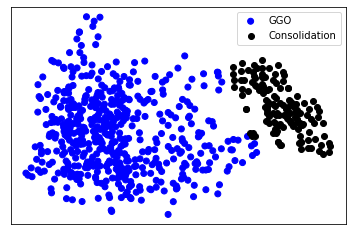

In [230]:
plt.figure()
plt.scatter(stome2[:,0],stome2[:,1],c =stomec2,label ='GGO')
# plt.scatter(datared[:,0],datared[:,1],c =colorred,label ='Consolidation')
plt.scatter(stmoeg2[:,0],stmoeg2[:,1],c = 'black',label ='Consolidation')
plt.xticks([])
plt.yticks([])
plt.legend()
plt.savefig(f'CNCB_tsne.jpg',bbox_inches='tight',dpi= 300)

In [26]:
print(color1[-3:])
print(data1[-3:])

['blue', 'red', 'red']
[[0.58850837 0.18125609]
 [0.2864719  0.6309002 ]
 [0.20433249 0.60265136]]


In [23]:
colorcncb = color.copy()
for i,c in enumerate(colorcncb):
    if c == 'green':
        colorcncb[i]='red'

In [51]:
# K_means = KMeans(4)
# t0 = time.time()
# K_means.fit(X_reduced)
# labels = K_means.labels_
# print(labels)
colour = [ "red", "blue", "green",'black']
# colour = [ "red", "blue", "green", "yellow", "purple", "orange", "black",\
#           '#FFB6C1','#4B0082','#778899','#E1FFFF','#8FBC8F','#808000','#FFEFD5','#CD853F' ]
color = list(map(lambda x: colour[x], labels))

[0 3 3 0 0 0 0 0 0 0 0 0 2 3 0 1 0 0 2 2 0 0 0 2 0 0 1 0 0 0 0 0 2 2 0 0 0
 0 0 0 0 0 2 0 0 2 2 0 0 0 0 0 0 0 0 2 0 0 2 2 0 2 0 2 0 2 2 2 2 0 0 0 3 3
 0 3 1 0 3 1 3 1 3 1 0 3 3 1 3 0 1 3 3 0 1 3 0 3 0 1 3 1 3 0 0 0 0 3 1 0 0
 1 3 0 1 0 0 1 3 0 3 1 3 0 1 0 1 0 3 0 1 3 0 1 3 3 1 0 1 0 0 3 3 0 1 3 1 0
 2 2]


In [195]:
data[0,:]

array([0.37132257, 0.4853149 ], dtype=float32)

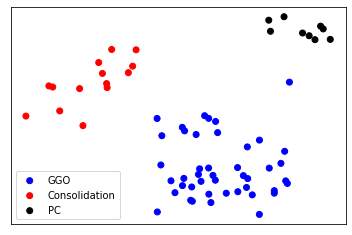

In [260]:
plt.figure()
plt.scatter(datablue[:,0],datablue[:,1],c =colorblue,label ='GGO')
plt.scatter(datared[:,0],datared[:,1],c =colorred,label ='Consolidation')
plt.scatter(datagreen[:,0],datagreen[:,1],c =colorgreen,label ='PC')
plt.xticks([])
plt.yticks([])
plt.legend()
plt.savefig(f'Lesion_tsne.jpg',bbox_inches='tight',dpi= 300)

In [48]:
for i in features:
    if all(i== centers[0]):
        print(i)

# 8. Visualization

In [ ]:
# p = '/'.join(img_path.split('/')[:-2])
# tag = '/'.join(img_path.split('/')[-2:])
# Ll_path = p+'/Lung_lesion/'+tag
# print(Ll_path)
# Ll_img = cv2.imread(Ll_path)
plt.figure()
plt.imshow(zoomed_lung_lesion1)
lesion_img2 = zoomed_lung_lesion1.copy()

lesion_img2[np.where(lesion_img2==1)] =0

plt.figure()
plt.imshow(lesion_img2)

lesion_img3 = np.where(lesion_img2== 0,0,1) 
plt.figure()
plt.imshow(lesion_img3)

labeled_img3, num = measure.label(lesion_img3*255,connectivity = 1, background = 0, return_num=True)
plt.figure()
plt.imshow(labeled_img3)
print(num)
properties3 = measure.regionprops(labeled_img3)
valid_box3 = []
for prop in properties3:
     if prop.area > 360:
        valid_box3.append(prop.bbox)
print(valid_box3)
print(valid_box)

print(len(valid_box3))
ratios = hit_rate(valid_box,valid_box3)
print(ratios)
# for box1 in valid_box3:
#     for box2 in valid_box:
#         y1,x1,y2,x2 = box1
#         y_1,x_1,y_2,x_2 = box2
#         ratio = DecideOberlap(x_1,y_1,x_2,y_2,x1,y1,x2,y2)
#         print(ratio)
# for i, box in enumerate(valid_box3):
#     heat_zeros = np.zeros((512,512))
#     heat_zeros[box[0]:box[2],box[1]:box[3]] = 1
#     plt.figure()
#     plt.imshow(heat_zeros)

In [ ]:
index = np.max(ratios,axis=1)
new_index = np.where(index>0.1,1,0)
print(new_index)

In [ ]:
gray_heatmap = cv2.cvtColor(heat1_map,cv2.COLOR_BGR2GRAY)
box_region = np.where(gray_heatmap > 150, 255, 0)

# print(thre1)
plt.figure()
plt.imshow(heat1_map)
plt.figure()
plt.imshow(box_region)
# cv2.imwrite('img_gray.jpg',img_gray)


labeled_img, num = measure.label(box_region,connectivity = 2, background = 0, return_num=True)
properties = measure.regionprops(labeled_img)
valid_box = []
for prop in properties:
    if prop.area > 800:
        valid_box.append(prop.bbox)
for i, box in enumerate(valid_box):
    heat_zeros = np.zeros((512,512))
    heat_zeros[box[0]:box[2],box[1]:box[3]] = 1
    plt.figure()
    plt.imshow(heat_zeros)

In [ ]:
print(img_class)
plt.figure()
plt.imshow(org_img)

In [ ]:
# print(lung_mask_seq.shape)
lung_mask_seq1 = lung_mask_seq/255
clip_ratio = 0.08
slices, height, width = lung_mask_seq1.shape
print(slices, height, width)
print(np.sum(lung_mask_seq1.reshape((slices, height*width)),axis= -1)/ (height*width))
#     print('lung_mask shape',slices, height, width) # lung_mask shape 56 512 512
lung_mask_ratio = np.sum(lung_mask_seq1.reshape((slices, height*width)), axis= 1) / (height*width) # 求z轴上的均值
print(lung_mask_ratio)
left, right = np.min(np.where(lung_mask_ratio > clip_ratio)), \
               np.max(np.where(lung_mask_ratio > clip_ratio)) # np.where(a > condition) 返回满足 Condition的索引 a[np.where()] 输出值
print(left, right)

In [ ]:
for i in range(img_seq.shape[0]-10):
    org_img  = img_seq[i+10,...]
    org_lung_mask = lung_mask_seq[i+10,...]/255
#     im = pil_image.fromarray(org_img)
#     im.save('test.tif')
    print(org_lung_mask.shape)
    n, bins, patches = plt.hist(x = org_lung_mask.flatten(), bins='auto', color='#0504aa',
                            alpha= 0.7, rwidth = 0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Pixel Histogram')
    print(type(org_img))
    
    plt.figure()
    plt.imshow(org_img)
    plt.figure()
    plt.imshow(org_lung_mask)
    plt.figure()
    plt.imshow(org_lung_mask*org_img)
    zoomed_org = zoomed_lung_region(org_img,org_lung_mask)
    plt.figure()
    plt.imshow(zoomed_org)
    cv2.imwrite('new_data_zoomed.jpg',zoomed_org*255)
#     plt.figure()
#     n, bins, patches = plt.hist(x= org_lung_mask.flatten(), bins='auto', color='#0504aa',
#                             alpha=0.7, rwidth=0.85)
#     plt.grid(axis='y', alpha=0.75)
#     plt.xlabel('Value')
#     plt.ylabel('Frequency')
#     plt.title('Piexl Histogram')
# #     print(type(org_img))
#     zoomed_org = zoomed_lung_region(org_img)
# #     print(type(zoomed_org))
#     plt.figure()
#     plt.imshow(zoomed_org)
# #     cv2.imwrite('new_data_zoomed.jpg',zoomed_org*255)
    
#     img = np.expand_dims(np.expand_dims(zoomed_org, axis = 0), axis=3)
#     prit = net.predict(img)
#     category_index = np.argmax(prit[0])
#     print(prit)
#     print(f'{i} prediction is:', np.argmax(prit[0]))
#     class_output = net.output[:, category_index]
#     cam_image, heat_map =  grad_cam(net,img,category_index,"post_relu")
#     plt.figure()
#     plt.imshow(cam_image)
    break 
# org_img  = img_seq[10,...]
# plt.imshow(org_img)
# zoomed_org = zoomed_lung_region(org_img)
# print(type(zoomed_org))

In [ ]:
org_img = cv2.imread('test.tif',cv2.IMREAD_UNCHANGED)
plt.figure()
n, bins, patches = plt.hist(x= org_img.flatten(), bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')

In [ ]:
def grad_cam(model, x, category_index, layer_name):
    """
    Args:
       model: model
       x: image input
       category_index: category index
       layer_name: last convolution layer name
    """
    # get category loss
    class_output = model.output[:, category_index]

    # layer output
    convolution_output = model.get_layer(layer_name).output
    # get gradients
    grads = K.gradients(class_output, convolution_output)[0]
    # get convolution output and gradients for input
    gradient_function = K.function([model.input], [convolution_output, grads])

    output, grads_val = gradient_function([x])
    output, grads_val = output[0], grads_val[0]
    print('output dtype', weights.dtype)
    print('output shape', weights.shape)
    # avg
    weights = np.mean(grads_val, axis=(0, 1))
    print('weight shape', weights.shape)
    
    cam = np.dot(output, weights) 
    print('after dot shape', cam.shape)

    # create heat map
    cam = cv2.resize(cam, (x.shape[1], x.shape[2]), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0) # 逐位比较 去掉非负值
    heatmap = cam / np.max(cam)

    # Return to BGR [0..255] from the preprocessed image
    image_rgb = x[0, :]
    image_rgb -= np.min(image_rgb)
    image_rgb = np.minimum(image_rgb, 255)
#     print('image_rgb shape: ', image_rgb.shape)
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
#     print('before combine : ', cam.shape)
    cam = np.float32(cam) + np.float32(image_rgb) 
#     print('after combine : ', cam.shape)
    cam = 255 * cam / np.max(cam)
# weight shape (2048,)
# dot shape (16, 16)
# image_rgb shape:  (512, 512, 1)
# before combine :  (512, 512, 3)
# after combine :  (512, 512, 3)
    
    return np.uint8(cam), heatmap

In [ ]:
if img_class == 0:
        org_img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED) # 获得图像
        print(type(org_img))
        img = np.expand_dims(np.expand_dims(org_img, axis = 0), axis=3)
        prit = net.predict(img) #[[9.9945074e-01 5.4921216e-04]]
        category_index = np.argmax(prit[0])
        if category_index == img_class:
            save_fea_path = f'./LUNG_image/Lung/{fold_num}_features'
            if not os.path.exists(save_fea_path):
                os.makedirs(save_fea_path)
#             f = open(f'./LUNG_image/Lung/{fold_num}_feature/{num}.txt','a+')
            # get category loss
            class_output = net.output[:, category_index]

            # layer output
            convolution_output = net.get_layer(layer_name).output
            # get gradients
            grads = K.gradients(class_output, convolution_output)[0]
            # get convolution output and gradients for input
            gradient_function = K.function([net.input], [convolution_output, grads])
            output, grads_val = gradient_function([img])
            output, grads_val = output[0], grads_val[0]
#                 print('output dtype:', output.dtype)
#                 print('output shape:',  output.shape)
            # avg
            weights = np.mean(grads_val, axis=(0, 1))
#                 print('weight shape', weights.shape)
            cam = np.dot(output, weights) # 16×16
            cam = np.maximum(cam,0)
            cam = cam/np.max(cam) 

In [ ]:
plt.imshow(org_img)

In [ ]:
prit

# 9. Model comparsion

LBP

In [4]:
import numpy as np
import pandas as pd
import pydicom
import os
import csv
import scipy.ndimage
import matplotlib.pyplot as plt
# import cPickle
import cv2

from sklearn.neural_network import MLPClassifier
from skimage import data, feature, measure, morphology #scikit-image
from sklearn import svm, metrics #scikit-learn
import sklearn.preprocessing as pre
from scipy import stats

def calculate_lbp(slice_data, numPoints, numNeighbors, radius, eps=1e-7):
	lbp_data = feature.local_binary_pattern(slice_data, numPoints, radius, method="uniform")
	n_bins = numPoints + 2
	(hist_data, _) = np.histogram(lbp_data.ravel(), bins=np.arange(0, n_bins+1), range=(0, n_bins))

	# Currently assuming last point in histogram is most frequent, getting rid of it (represents grey matter)
	hist_data = hist_data[:-1]

	# Normalize the histogram
	hist_data = hist_data.astype("float")
	hist_data /= (hist_data.sum() + eps)

	return hist_data
radius = 3
numNeighbors = 8
numPoints = numNeighbors * radius

def calcaulat_HOG(img):
    #在这里设置参数
    winSize = (128,128)
    blockSize = (64,64)
    blockStride = (8,8)
    cellSize = (16,16)
    nbins = 9

    #定义对象hog，同时输入定义的参数，剩下的默认即可
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
    
    winStride = (8,8)
    padding = (8,8)
    test_hog = hog.compute(img, winStride, padding).reshape((-1,))
    return test_hog

In [4]:
radius = 3
numNeighbors = 8
numPoints = numNeighbors * radius

In [44]:
train_df = pd.read_csv('CSV/Lesion/lesion_train1.csv')
validation_df = pd.read_csv('CSV/Lesion/lesion_validation1.csv')

train_datagen = ImageDataGenerator()
validation_datagen =  ImageDataGenerator()
train_df = shuffle(train_df)
shape=(512,512,1) 
train_generator = train_datagen.flow_from_dataframe(
      dataframe = train_df,
      directory= None,
      x_col="filename",
      y_col="class",
      target_size=shape[:2],
      batch_size= 10,
      class_mode='categorical',color_mode="grayscale",shuffle=True)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe = validation_df,
        directory = None,
        x_col="filename",
        y_col="class",
        target_size=shape[:2],
        batch_size= 10,
        class_mode='categorical', color_mode="grayscale",shuffle=True)

Found 292 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.


In [5]:
t_imgs = train_generator.filenames
t_img_classes = train_generator.classes
v_imgs = validation_generator.filenames
v_img_classes = validation_generator.classes

In [6]:
#64 hist 
output_training_hist = []
for img_path in t_imgs:
    base_slice = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
    hist_data =  cv2.calcHist([base_slice],[0],None,[64],[0,255])
    output_training_hist.append(np.squeeze(hist_data))

output_validation_hist = []
for img_path in v_imgs:
    base_slice = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
    hist_data =  cv2.calcHist([base_slice],[0],None,[64],[0,255])
    output_validation_hist.append(np.squeeze(hist_data))

In [7]:
# LBP
output_training_data = []
for img_path in t_imgs:
    base_slice = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
    hist_data = calculate_lbp(base_slice, numPoints, numNeighbors, radius)
    output_training_data.append(hist_data)
    
output_validation_data = []
for img_path in v_imgs:
    base_slice = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
    hist_data = calculate_lbp(base_slice, numPoints, numNeighbors, radius)
    output_validation_data.append(hist_data)

In [1]:
names = ['LBP','64hist','HOG']
for f_name in names:  
    if f_name == 'LBP':
        clf1 = svm.SVC()
        clf1.fit(output_training_data, t_img_classes)
        v_result = clf1.predict(output_validation_data)
        print('accuracy of %s with SVM is %f'%(f_name,len(np.where(v_result == v_img_classes)[0])/96))
        
        mlp = MLPClassifier(solver='sgd', activation='tanh',alpha=1e-2,hidden_layer_sizes=(64,64,64), random_state=1,max_iter=50,verbose=10,learning_rate_init=.1)
        mlp.fit(output_training_data , t_img_classes) 
        s = mlp.score(output_validation_data,v_img_classes)
        print('accuracy of %s with MLP is %f'%(f_name,s))
        
#     if f_name == '64hist':
#         clf2 = svm.SVC()
#         clf2.fit(output_training_hist, t_img_classes)
#         v_result = clf2.predict(output_validation_hist)
#         print('accuracy of %s with SVM is %f'%(f_name,len(np.where(v_result == v_img_classes)[0])/96))
              
#         mlp = MLPClassifier(solver='sgd', activation='tanh',alpha=1e-2,hidden_layer_sizes=(25,10,2), random_state=1,max_iter=50,verbose=10,learning_rate_init=.01)
#         mlp.fit(output_training_hist, t_img_classes) 
#         s = mlp.score(output_validation_hist,v_img_classes)
#         print('accuracy of %s with MLP is %f'%(f_name,s))

#     if f_name == 'HOG':
#         clf.fit(output_training_data, t_img_classes)
#         v_result = clf.predict(output_validation_hist)
#         print('accuracy of %s with SVM is %d'%(f_name,len(np.where(v_result == v_img_classes)[0])/96))

In [63]:
mlp = MLPClassifier(solver='sgd', activation='relu',alpha=1e-4,hidden_layer_sizes=(64,64,2), random_state=1,max_iter=50,verbose=10,learning_rate_init=.1)
mlp.fit(output_training_data , t_img_classes) 

Iteration 1, loss = 0.91227612
Iteration 2, loss = 0.84243211
Iteration 3, loss = 0.74483635
Iteration 4, loss = 0.69020882
Iteration 5, loss = 0.70230216
Iteration 6, loss = 0.71047789
Iteration 7, loss = 0.69510086
Iteration 8, loss = 0.68717135
Iteration 9, loss = 0.68621533
Iteration 10, loss = 0.68625266
Iteration 11, loss = 0.68646400
Iteration 12, loss = 0.68614297
Iteration 13, loss = 0.68550724
Iteration 14, loss = 0.68499971
Iteration 15, loss = 0.68565342
Iteration 16, loss = 0.68523814
Iteration 17, loss = 0.68521026
Iteration 18, loss = 0.68444224
Iteration 19, loss = 0.68422748
Iteration 20, loss = 0.68418528
Iteration 21, loss = 0.68415524
Iteration 22, loss = 0.68393588
Iteration 23, loss = 0.68381555
Iteration 24, loss = 0.68312489
Iteration 25, loss = 0.68319657
Iteration 26, loss = 0.68248253
Iteration 27, loss = 0.68209607
Iteration 28, loss = 0.68174363
Iteration 29, loss = 0.68149404
Iteration 30, loss = 0.68062653
Iteration 31, loss = 0.68053912
Iteration 32, los

/root/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(hidden_layer_sizes=(64, 64, 2), learning_rate_init=0.1,
              max_iter=50, random_state=1, solver='sgd', verbose=10)

In [60]:
print(output_training_data[0].shape)

(25,)


In [64]:
mlp.score(output_validation_data,v_img_classes)

0.5208333333333334